# REINFORCE with gym environment - Cartpole

---

In this notebook, an agent is trained with REINFORCE algorithm to solve OpenAI Gym's Cartpole-v1 environment.

https://www.gymlibrary.dev/environments/classic_control/cart_pole/

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

/Users/tamoghnadas/opt/anaconda3/envs/drlnd/lib/python3.6/site-packages/gym/core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [2]:
import sys
print("Python version info:", sys.version_info)
print("gym version:" , gym.__version__)
print("Pytorch version:", torch.__version__)

Python version info: sys.version_info(major=3, minor=6, micro=13, releaselevel='final', serial=0)
gym version: 0.26.2
Pytorch version: 1.0.0


#### Explore the environment

In [3]:
env = gym.make('CartPole-v1')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
env.close()

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


### 2. Define the Architecture of the Policy

In [4]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2): #s_size=4 corresponds to state space, a_size=2 corresponds to action space
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs) #Ref: https://pytorch.org/docs/stable/distributions.html#categorical
        action = m.sample() #action is a tensor with only one element
        return action.item(), m.log_prob(action) # tensor.item() Returns the value of this tensor as a standard Python number
                                                 # Ref: https://pytorch.org/docs/stable/generated/torch.Tensor.item.html
                                                 # Ref for log_prob: https://pytorch.org/docs/stable/distributions.html#categorical
                                                 #                  https://stackoverflow.com/questions/54635355/what-does-log-prob-do

### Visualize the environment; actions created by an untrained network

In [5]:
env = gym.make('CartPole-v1',render_mode="human")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = Policy().to(device)

state, info  = env.reset()

for j in range(1000):
    action, log_prob = policy.act(state)
    env.render()
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        state, info = env.reset()
        # break
    

env.close()

### 3. Train the Agent with REINFORCE

In [ ]:
env = gym.make('CartPole-v1')
#env.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state,info = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(policy.state_dict(), 'checkpoint1_CartPole.pth')
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 27.85
Episode 200	Average Score: 47.55
Episode 300	Average Score: 89.61
Episode 400	Average Score: 97.05
Episode 500	Average Score: 84.34
Episode 600	Average Score: 68.96
Episode 700	Average Score: 43.12
Episode 800	Average Score: 61.51


In [6]:
env.close()

### 4. Plot the Scores

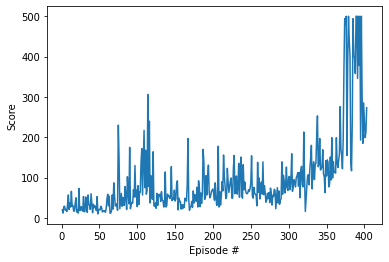

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [10]:
# load the weights from file
policy.load_state_dict(torch.load('checkpoint1_CartPole.pth'))

env = gym.make('CartPole-v1',render_mode="human")

state,info = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break 

env.close()